In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import random_split
import matplotlib.pyplot as plt


In [2]:
#loading dataset
dataset = datasets.SVHN(root="data", download=True, transform=ToTensor())
test_svhn = datasets.SVHN(root="data", split="test", download=True, transform=ToTensor())


100%|██████████| 182040794/182040794 [00:05<00:00, 33464281.41it/s]


100%|██████████| 64275384/64275384 [00:02<00:00, 22569249.70it/s]


In [3]:
dataset

Dataset SVHN
    Number of datapoints: 73257
    Root location: data
    Split: train
    StandardTransform
Transform: ToTensor()

In [4]:
test_svhn

Dataset SVHN
    Number of datapoints: 26032
    Root location: data
    Split: test
    StandardTransform
Transform: ToTensor()

In [5]:
#splitting dataset (svhn) into training and validation set
val_split_ratio = 0.2

#randomly split the training set
train_size = int(len(dataset) * (1 - val_split_ratio))
val_size = len(dataset) - train_size

train_svhn, val_svhn = random_split(dataset, [train_size, val_size])


In [33]:
#creating dataloaders for each set
train_loader = DataLoader(train_svhn, batch_size=384, shuffle=True)
val_loader = DataLoader(val_svhn, batch_size=512, shuffle=False)
test_loader = DataLoader(test_svhn, batch_size=512, shuffle=False)


In [34]:
#autoencoder
class UCAutoencoder(nn.Module): #UnderComplete Autoencoder
    def __init__(self,input_dim, latent_dim):
        super(UCAutoencoder, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, int(input_dim*0.5)),
            nn.ReLU(),
            nn.Linear(int(input_dim*0.5), int(input_dim*0.25)),
            nn.ReLU(),
            nn.Linear(int(input_dim*0.25), latent_dim)
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, int(input_dim*0.25)),
            nn.ReLU(),
            nn.Linear(int(input_dim*0.25), int(input_dim*0.5)),
            nn.ReLU(),
            nn.Linear(int(input_dim*0.5), input_dim),
            nn.Sigmoid()  # Sigmoid activation to squash output between 0 and 1
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_dim=1024
latent_dim=32
model = UCAutoencoder(input_dim, latent_dim).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001) #creating an optimizer object
criterion = nn.MSELoss() #mean-squared error loss

In [36]:
#training the autoencoder model
epochs=15
epochh=[]
losses=[]

for epoch in range(epochs):
    loss = 0
    for batch_features, _ in train_loader:

        batch_features = batch_features.view(-1, input_dim).to(device) #reshaping mini-batch data to [N, 784] matrix and loading it
        optimizer.zero_grad() #resetting the gradients back to zero
        outputs = model(batch_features) # computing reconstruction

        train_loss = criterion(outputs, batch_features) #computing training recons. loss
        train_loss.backward() #computing accumulated gradients
        optimizer.step() #parameter update
        loss += train_loss.item() #adding the mini-batch training loss to epoch loss

    loss = loss / len(train_loader) #computing the epoch training loss
    epochh.append(epoch+1)
    losses.append(loss)

    print("epoch : {}/{}, recon loss = {:.8f}".format(epoch + 1, epochs, loss))


epoch : 1/15, recon loss = 0.01783450
epoch : 2/15, recon loss = 0.01152925
epoch : 3/15, recon loss = 0.00965638
epoch : 4/15, recon loss = 0.00962322
epoch : 5/15, recon loss = 0.00885108
epoch : 6/15, recon loss = 0.00795074
epoch : 7/15, recon loss = 0.00717669
epoch : 8/15, recon loss = 0.00705558
epoch : 9/15, recon loss = 0.00697512
epoch : 10/15, recon loss = 0.00672122
epoch : 11/15, recon loss = 0.00630323
epoch : 12/15, recon loss = 0.00614427
epoch : 13/15, recon loss = 0.00592047
epoch : 14/15, recon loss = 0.00584702
epoch : 15/15, recon loss = 0.00568354


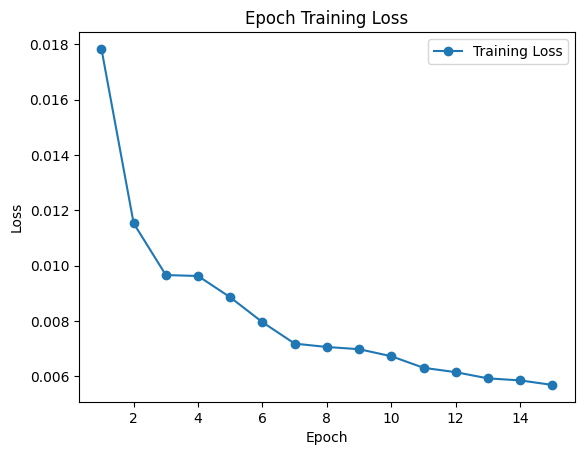

In [37]:
#Plotting the graph
plt.plot(epochh, losses, marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch Training Loss')
plt.legend()
plt.show()


In [43]:
#result evaluation
test_loader = DataLoader(test_svhn, batch_size=128, shuffle=False)
test_example = None
model = model.to(device)

with torch.no_grad():
    for batch_features in test_loader:
        batch_features = batch_features[0]
        batch_features=batch_features.to(device)
        test_examples = batch_features.view(-1, input_dim)
        reconstruction = model(test_examples)
        break

In [ ]:
import torch
import torch.nn.functional as F
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#defining evaluation functions
test_loader = DataLoader(test_svhn, batch_size=128, shuffle=False)
model = model.to(device)

def calculate_psnr(original, reconstructed):
    #tensors to NumPy arrays
    original = original.cpu().detach().numpy().transpose(1, 2, 0)
    original = original.to(device)
    reconstructed = reconstructed.cpu().detach().numpy().transpose(1, 2, 0)
    reconstructed = reconstructed.to(device)


    psnr_scores = []
    for i in range(original.shape[0]):
        psnr_scores.append(psnr(original[i], reconstructed[i]))

    return torch.tensor(psnr_scores).mean()

#evaluating on test data
total_ssim, total_psnr = 0, 0
with torch.no_grad():
    for batch_features, _ in test_loader:
        batch_features = batch_features.to(device)
        outputs = model(batch_features)
        batch_psnr = calculate_psnr(batch_features, outputs)

        total_psnr += batch_psnr

average_psnr = total_psnr / len(test_loader)

print(f"Average PSNR: {average_psnr:.4f}")


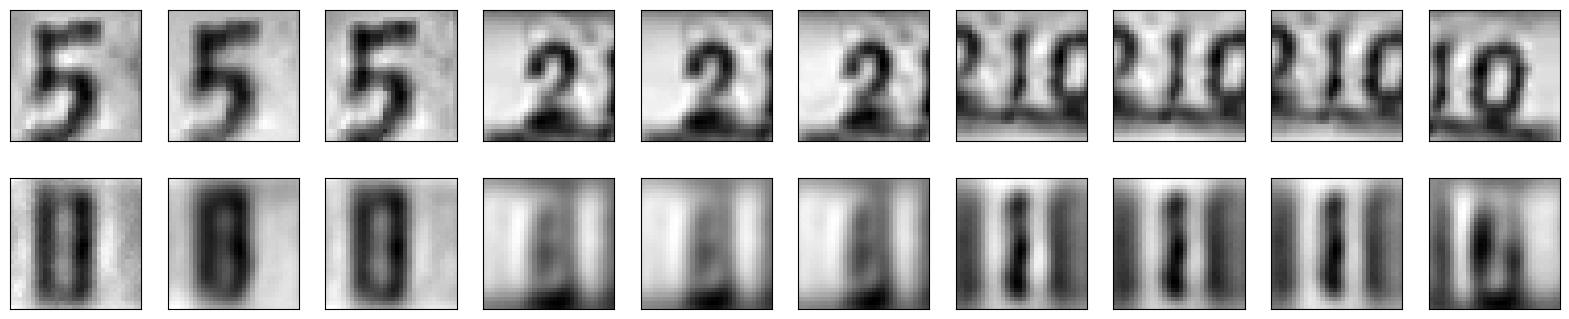

In [46]:
#visualizing result

with torch.no_grad():
    number = 10
    plt.figure(figsize=(20, 4))
    for index in range(number):
        # display original
        ax = plt.subplot(2, number, index + 1)
        plt.imshow(test_examples[index].cpu().numpy().reshape(32, 32))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, number, index + 1 + number)
        plt.imshow(reconstruction[index].cpu().numpy().reshape(32, 32))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [51]:
#adding random noise to the input dataimport torch

def add_gaussian_noise(data, mean=0, std=0.1):
  for image, _ in dataset:
    image_shape = image.shape

  noise = torch.randn(image_shape) * std + mean
  return data + noise

noisy_svhn = add_gaussian_noise(dataset) #adding noise to SVHN data


In [59]:
#denoising Autoencoder

def noise_input(images):
    return images * (1 - NOISE_RATIO) + torch.rand(images.size()) * NOISE_RATIO
NOISE_RATIO = 0.4
noise_images = noise_input(test_examples.cpu())

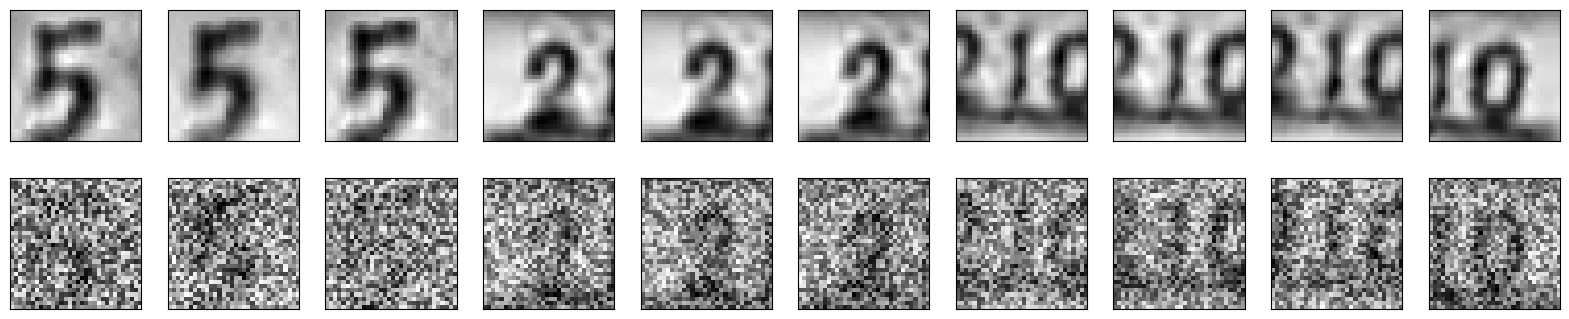

In [54]:
with torch.no_grad():
    number = 10
    plt.figure(figsize=(20, 4))
    for index in range(number):
        # display original
        ax = plt.subplot(2, number, index + 1)
        plt.imshow(test_examples[index].cpu().numpy().reshape(32, 32))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, number, index + 1 + number)
        plt.imshow(noise_images[index].cpu().numpy().reshape(32, 32))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()